In [120]:
import numpy
import AGG
import pysam
import seaborn as sns
import pandas as pd
import random

In [125]:
directory = "./Mixture/mixture_eval_HG00733/"
directory = "./mt_test_eval_shortread/"
tp = "tp.vcf.gz"
fp = "fp.vcf.gz"

In [126]:
def extract_features(filename, label):
    labels = []
    length = []
    HFlist = []
    vcf_file = pysam.VariantFile(filename)
    samplelist = list(vcf_file.header.samples)
    for record in vcf_file:
        ref = record.ref
        alt = record.alts[0]
        sample = samplelist[0]
        hf = record.samples[sample]['HF']
        labels.append(label) # truth
        length.append(len(ref) - len(alt))
        HFlist.append(hf)
    return labels, length, HFlist

tp_labels, tp_length, tp_HFlist = extract_features(directory + tp, 1)
fp_labels, fp_length, fp_HFlist = extract_features(directory + fp, 0)
index = random.sample(range(len(fp_labels)), len(tp_labels))
fp_labels_sampled = [fp_labels[i] for i in index]
fp_length_sampled = [fp_length[i] for i in index]
fp_HFlist_sampled = [fp_HFlist[i] for i in index]
all_labels = tp_labels + fp_labels_sampled
all_length = tp_length + fp_length_sampled
all_HFlist = tp_HFlist + fp_HFlist_sampled


<Axes: xlabel='Length Difference', ylabel='Heteroplasmic Frequency'>

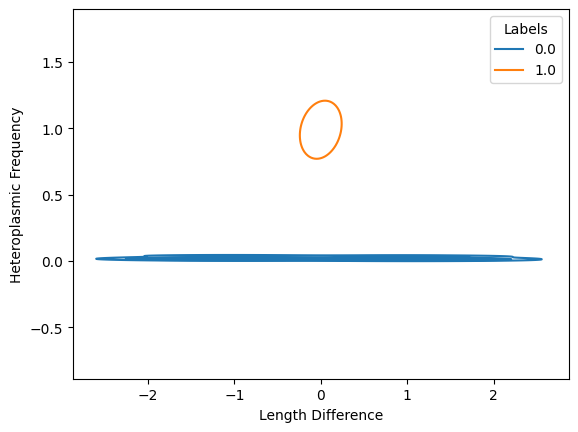

In [127]:
df = pd.DataFrame([all_labels, all_length, all_HFlist], index = ["Labels", "Length Difference", "Heteroplasmic Frequency"])
sns.kdeplot(df.T, x = "Length Difference", y = "Heteroplasmic Frequency", hue = "Labels")

<Axes: ylabel='Count'>

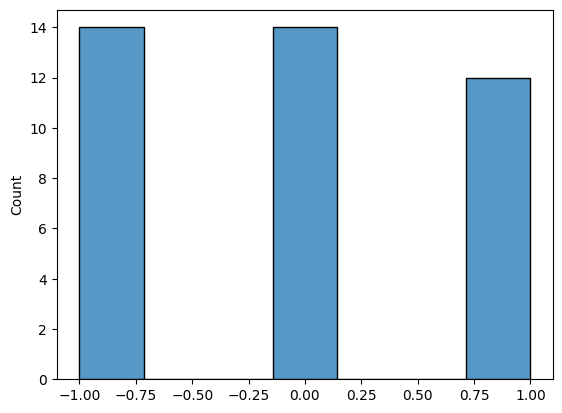

In [128]:
sns.histplot(all_length)

In [131]:
# Train a svm model
from sklearn import svm
from sklearn.model_selection import train_test_split, GridSearchCV, cross_val_score
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_curve, auc
from sklearn.pipeline import Pipeline
from sklearn.datasets import make_classification
from matplotlib import pyplot as plt
import numpy as np
def train_svm(X_train, y_train, kernel='rbf', C=1.0, gamma='scale'):
    """
    Train an SVM model for binary classification.
    
    Parameters:
    -----------
    X_train : numpy.ndarray
        Training features
    y_train : numpy.ndarray
        Training labels
    kernel : str
        Kernel type ('linear', 'rbf', 'poly', 'sigmoid')
    C : float
        Regularization parameter
    gamma : str or float
        Kernel coefficient for 'rbf', 'poly' and 'sigmoid'
        
    Returns:
    --------
    model : sklearn.svm.SVC
        Trained SVM model
    """
    # Create model
    model = svm.SVC(
        kernel=kernel,
        C=C,
        gamma=gamma,
        probability=True,  # Enable probability estimates
        random_state=42
    )
    
    # Train model
    model.fit(X_train, y_train)
    
    return model

def evaluate_model(model, X_test, y_test):
    """
    Evaluate SVM model performance.
    
    Parameters:
    -----------
    model : sklearn.svm.SVC
        Trained SVM model
    X_test : numpy.ndarray
        Test features
    y_test : numpy.ndarray
        Test labels
        
    Returns:
    --------
    metrics : dict
        Dictionary with evaluation metrics
    """
    # Get predictions
    y_pred = model.predict(X_test)
    y_prob = model.predict_proba(X_test)[:, 1]  # Probability of class 1
    
    # Calculate metrics
    report = classification_report(y_test, y_pred, output_dict=True)
    cm = confusion_matrix(y_test, y_pred)
    
    # Calculate ROC curve and AUC
    fpr, tpr, _ = roc_curve(y_test, y_prob)
    roc_auc = auc(fpr, tpr)
    
    # Display results
    print("Classification Report:")
    print(classification_report(y_test, y_pred))
    
    print("\nConfusion Matrix:")
    print(cm)
    
    # Visualize ROC curve
    plt.figure(figsize=(8, 6))
    plt.plot(fpr, tpr, color='darkorange', lw=2, 
             label=f'ROC curve (area = {roc_auc:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Receiver Operating Characteristic')
    plt.legend(loc="lower right")
    plt.show()
    
    return report
# visualizing SVM boundaries
def plot_decision_boundary(model, X, y, feature_names, feature_idx=(0, 1)):
    """
    Plot SVM decision boundary for two selected features.
    
    Parameters:
    -----------
    model : sklearn.svm.SVC
        Trained SVM model
    X : numpy.ndarray
        Feature matrix
    y : numpy.ndarray
        Target vector
    feature_idx : tuple
        Indices of two features to plot
        
    Returns:
    --------
    fig : matplotlib.figure.Figure
        Figure object
    """
    # Extract the two selected features
    X_subset = X[:, feature_idx]
    
    # Create a mesh grid
    h = 0.02  # Step size in the mesh
    x_min, x_max = X_subset[:, 0].min() - 1, X_subset[:, 0].max() + 1
    y_min, y_max = X_subset[:, 1].min() - 1, X_subset[:, 1].max() + 1
    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))
    
    # Create scaler and transform selected features
    scaler = StandardScaler()
    X_subset_scaled = scaler.fit_transform(X_subset)
    
    # Get min/max values for the scaled features
    x_min_scaled, x_max_scaled = X_subset_scaled[:, 0].min() - 1, X_subset_scaled[:, 0].max() + 1
    y_min_scaled, y_max_scaled = X_subset_scaled[:, 1].min() - 1, X_subset_scaled[:, 1].max() + 1
    
    # Create mesh grid for scaled features
    xx_scaled, yy_scaled = np.meshgrid(np.arange(x_min_scaled, x_max_scaled, h),
                                      np.arange(y_min_scaled, y_max_scaled, h))
    
    # Create pipeline with scaling and model
    pipeline = Pipeline([
        ('scaler', scaler),
        ('svm', model)
    ])
    
    # Plot the decision boundary
    fig, ax = plt.subplots(figsize=(10, 8))
    
    # Get model prediction on the mesh grid
    Z = pipeline.predict(np.c_[xx.ravel(), yy.ravel()])
    Z = Z.reshape(xx.shape)
    
    # Plot the decision boundary and margins
    ax.contourf(xx, yy, Z, alpha=0.8, cmap=plt.cm.RdBu)
    
    # Plot training points
    scatter = ax.scatter(X_subset[:, 0], X_subset[:, 1], c=y, 
                        edgecolor='k', s=50, cmap=plt.cm.RdBu)
    
    # Highlight support vectors
    if hasattr(model, 'support_vectors_'):
        # Reverse transform support vectors to original scale
        sv_scaled = model.support_vectors_
        sv = scaler.inverse_transform(sv_scaled)
        ax.scatter(sv[:, 0], sv[:, 1], s=100, linewidth=1, 
                  facecolors='none', edgecolors='k')
    
    ax.set_xlim(xx.min(), xx.max())
    ax.set_ylim(yy.min(), yy.max())
    ax.set_xlabel(f'Feature {feature_idx[0]}: {feature_names[feature_idx[0]]}')
    ax.set_ylabel(f'Feature {feature_idx[1]}: {feature_names[feature_idx[1]]}')
    ax.set_title(f'SVM Decision Boundary (kernel={model.kernel})')
    plt.colorbar(scatter)
    
    return fig


Fitting 5 folds for each of 140 candidates, totalling 700 fits
Best parameters: {'svm__C': 1, 'svm__gamma': 'scale', 'svm__kernel': 'rbf'}
Best cross-validation score: 0.8000


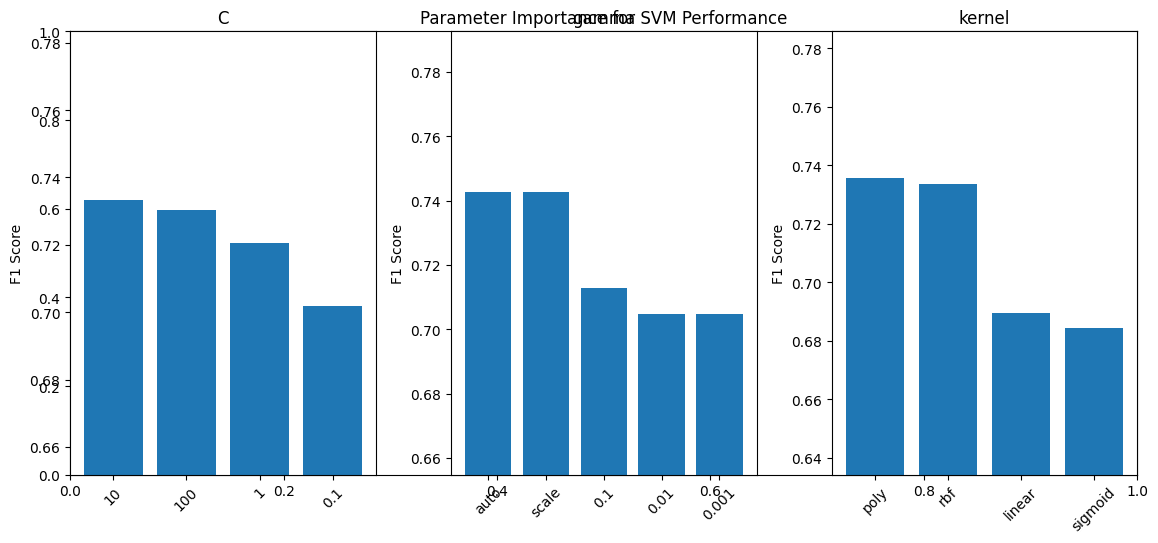

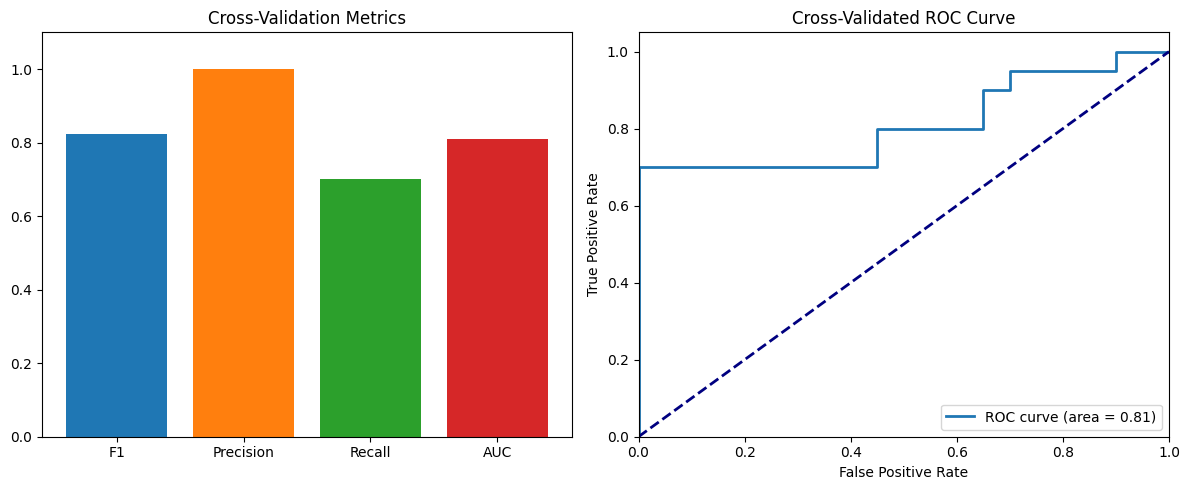

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91         5
         1.0       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10


Confusion Matrix:
[[5 0]
 [1 4]]


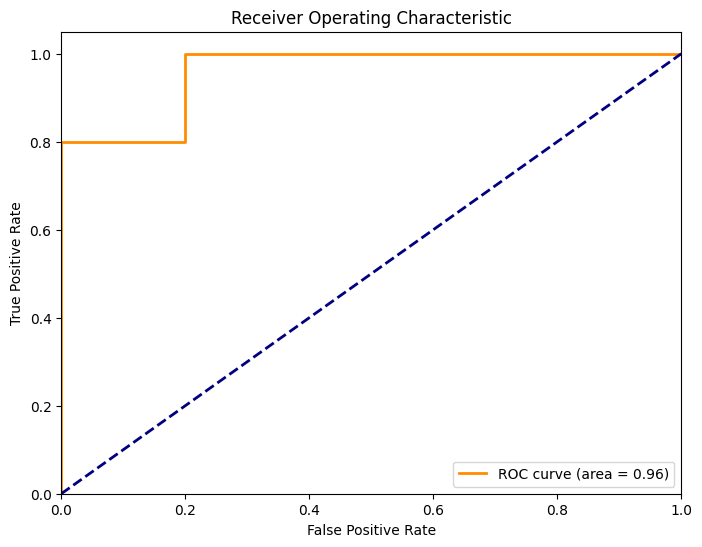

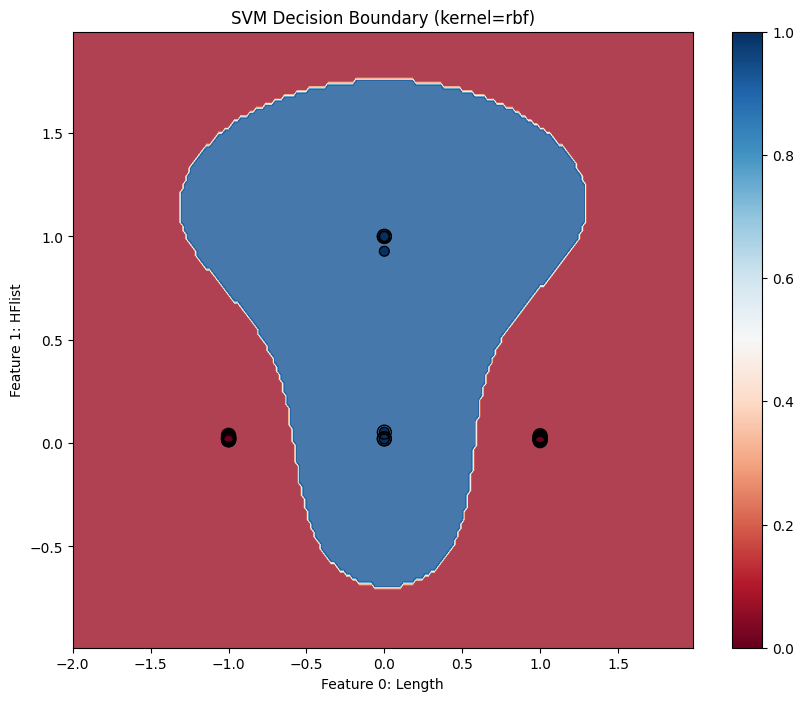

In [135]:
from sklearn.model_selection import GridSearchCV, cross_val_predict
from sklearn.metrics import f1_score, precision_score, recall_score, roc_auc_score

def tune_svm_parameters(X, y, cv=5):
    """
    Tune SVM hyperparameters using GridSearchCV.
    
    Parameters:
    -----------
    X : numpy.ndarray or pandas.DataFrame
        Features
    y : numpy.ndarray or pandas.Series
        Target labels
    cv : int, default 5
        Number of cross-validation folds
        
    Returns:
    --------
    best_model : sklearn.pipeline.Pipeline
        Tuned pipeline with the best parameters
    param_importance : dict
        Parameter importance information
    """
    # Create a pipeline with standardization and SVM
    pipe = Pipeline([
        ('scaler', StandardScaler()),
        ('svm', svm.SVC(probability=True, random_state=42))
    ])
    
    # Define parameter grid
    param_grid = {
        'svm__kernel': ['linear', 'rbf', 'poly', 'sigmoid'],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto', 0.1, 0.01, 0.001]
    }
    
    # For polynomial kernel, add degree parameter
    poly_param_grid = {
        'svm__kernel': ['poly'],
        'svm__C': [0.1, 1, 10, 100],
        'svm__gamma': ['scale', 'auto', 0.1, 0.01, 0.001],
        'svm__degree': [2, 3, 4]
    }
    
    # Combine parameter grids
    full_param_grid = [param_grid, poly_param_grid]
    
    # Create grid search
    grid = GridSearchCV(
        pipe, 
        full_param_grid, 
        cv=cv, 
        scoring='f1',
        n_jobs=-1,
        verbose=1,
        return_train_score=True
    )
    
    # Fit grid search
    grid.fit(X, y)
    
    # Print results
    print(f"Best parameters: {grid.best_params_}")
    print(f"Best cross-validation score: {grid.best_score_:.4f}")
    
    # Parameter importance analysis (simplified)
    results = grid.cv_results_
    param_importance = {}
    
    for param_name in grid.best_params_.keys():
        unique_values = set(results[f'param_{param_name}'])
        scores = []
        
        for value in unique_values:
            indices = [i for i, p in enumerate(results[f'param_{param_name}']) if p == value]
            avg_score = np.mean([results['mean_test_score'][i] for i in indices])
            scores.append((value, avg_score))
        
        param_importance[param_name] = sorted(scores, key=lambda x: x[1], reverse=True)
    
    # Visualize parameter importance
    plt.figure(figsize=(12, 6))
    plt.title("Parameter Importance for SVM Performance")
    
    # Plot top parameters
    for i, (param, values) in enumerate(param_importance.items()):
        # Select top values for clarity
        top_values = values[:5] if len(values) > 5 else values
        
        plt.subplot(1, len(param_importance), i+1)
        param_name = param.replace('svm__', '')
        plt.title(f"{param_name}")
        
        # Extract values and scores
        vals = [str(v[0]) for v in top_values]
        scores = [v[1] for v in top_values]
        
        plt.bar(vals, scores)
        plt.ylim(min(scores) - 0.05, max(scores) + 0.05)
        plt.xticks(rotation=45)
        plt.ylabel('F1 Score')
    
    plt.tight_layout()
    plt.show()
    
    return grid.best_estimator_, param_importance

# Add a function to visualize cross-validation performance
def plot_cv_performance(X, y, best_model, cv=5):
    """Plot cross-validation performance metrics"""
    # Get cross-validated predictions
    y_pred = cross_val_predict(best_model, X, y, cv=cv)
    y_prob = cross_val_predict(best_model, X, y, cv=cv, method='predict_proba')[:, 1]
    
    # Calculate metrics
    f1 = f1_score(y, y_pred)
    precision = precision_score(y, y_pred)
    recall = recall_score(y, y_pred)
    roc_auc_value = roc_auc_score(y, y_prob)
    
    # Create plot
    plt.figure(figsize=(12, 5))
    
    # Plot metrics
    plt.subplot(1, 2, 1)
    metrics = ['F1', 'Precision', 'Recall', 'AUC']
    values = [f1, precision, recall, roc_auc_value]
    plt.bar(metrics, values, color=['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728'])
    plt.ylim(0, 1.1)
    plt.title('Cross-Validation Metrics')
    
    # Plot ROC curve
    plt.subplot(1, 2, 2)
    fpr, tpr, _ = roc_curve(y, y_prob)
    plt.plot(fpr, tpr, lw=2, label=f'ROC curve (area = {roc_auc_value:.2f})')
    plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
    plt.xlim([0.0, 1.0])
    plt.ylim([0.0, 1.05])
    plt.xlabel('False Positive Rate')
    plt.ylabel('True Positive Rate')
    plt.title('Cross-Validated ROC Curve')
    plt.legend(loc="lower right")
    
    plt.tight_layout()
    plt.show()
    
    return {
        'f1': f1,
        'precision': precision,
        'recall': recall,
        'roc_auc': roc_auc_value
    }

# Usage example:
# First run parameter tuning
X = df.T[['Length Difference', "Heteroplasmic Frequency"]]
Y = df.T["Labels"]

# Tune parameters
best_model, param_importance = tune_svm_parameters(X, Y, cv=5)

# Evaluate with cross-validation
cv_metrics = plot_cv_performance(X, Y, best_model, cv=5)

# Split data for final evaluation
X_train, X_test, y_train, y_test = train_test_split(
    X, Y, test_size=0.25, random_state=42, stratify=Y)

# Evaluate on test set
metrics = evaluate_model(best_model, X_test, y_test)

# Plot decision boundary
plot_figure = plot_decision_boundary(
    best_model.named_steps['svm'], 
    X.values, 
    Y.values, 
    ["Length", "HFlist"]
)

Classification Report:
              precision    recall  f1-score   support

         0.0       0.83      1.00      0.91         5
         1.0       1.00      0.80      0.89         5

    accuracy                           0.90        10
   macro avg       0.92      0.90      0.90        10
weighted avg       0.92      0.90      0.90        10


Confusion Matrix:
[[5 0]
 [1 4]]


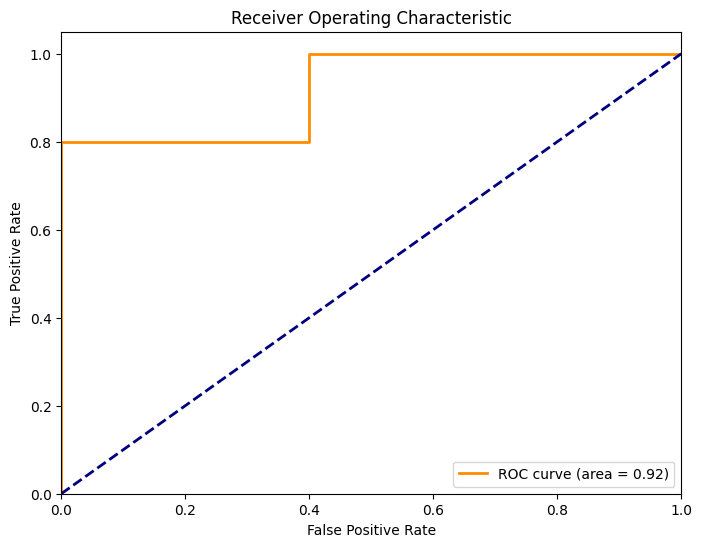

/Users/suhang/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


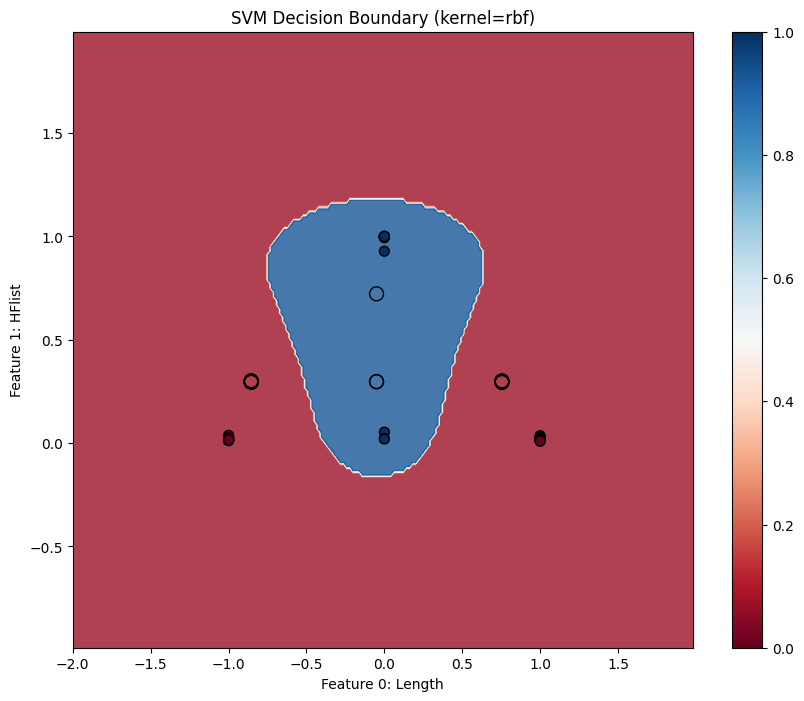

In [132]:



# Make predictions
y_pred = svm_model.predict(X_test)

metrics = evaluate_model(svm_model, X_test, y_test)

# Select two features for visualization (e.g., the first two)
feature_pair = (0, 1)

# Plot decision boundary using the best model
# best_svm_model = svm_model.named_steps['svm']
plot_figure = plot_decision_boundary(svm_model, X.values, Y.values, ["Length", "HFlist"], feature_pair)


In [73]:
filename = "mt_test.annotated.gfa"
vcffile = "mt_test.vcf.gz"
graph = AGG.GraphicalGenome(filename=filename)
_, length, HFlist = extract_features(vcffile, 0)
data = numpy.array([length, HFlist]).T
scaler = StandardScaler()
new_data_scaled = scaler.fit_transform(data)

# Make predictions
predictions = svm_model.predict(new_data_scaled)

# Get probabilities
probabilities = svm_model.predict_proba(new_data_scaled)



/Users/suhang/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(
/Users/suhang/miniconda3/lib/python3.10/site-packages/sklearn/base.py:465: UserWarning: X does not have valid feature names, but SVC was fitted with feature names
  warnings.warn(


In [80]:
excluded = []
for i, (p, prob) in enumerate(zip(predictions, probabilities)):
    if max(prob) > 0.7 and p == 0:
        excluded.append(i)

count = 0
vcf_file = pysam.VariantFile(vcffile)
samplelist = list(vcf_file.header.samples)
output_vcf = pysam.VariantFile("mt_test_svmfiltered.vcf.gz", 'w', header=vcf_file.header)

for record in vcf_file:
    ref = record.ref
    alt = record.alts[0]
    sample = samplelist[0]
    hf = record.samples[sample]['HF']
    if count in excluded:
        print(ref, alt, hf)
    else:
        output_vcf.write(record)
    count += 1
output_vcf.close()

TG T 0.022015700116753578
C CA 0.01617800071835518
A AC 0.02959500066936016
T TC 0.028037400916218758
AC A 0.011940300464630127
C CA 0.013432799838483334
CT C 0.01061679981648922
AC A 0.014410699717700481
A AC 0.042717400938272476
A AT 0.018013399094343185
TC T 0.024189399555325508
TC T 0.01235199999064207
AC A 0.010536899790167809
A AC 0.02007020078599453
AC A 0.010025099851191044
AC A 0.01488099992275238
AC A 0.032242100685834885
A AC 0.022321399301290512
AC A 0.016806699335575104
TC T 0.021972699090838432
CA C 0.012801599688827991
AC A 0.016757000237703323
A AC 0.013306999579071999
CG C 0.017249900847673416
AC A 0.012713899835944176
AC A 0.012297100387513638
A AC 0.06197740137577057
TC T 0.015740299597382545
TA T 0.012701500207185745
T TA 0.02491449937224388
TG T 0.022893300279974937
AC A 0.01125240046530962
AC A 0.02373890019953251
AG A 0.011442800052464008
G GA 0.011442800052464008
AC A 0.01584940031170845
A AC 0.037642400711774826
TG T 0.011437100358307362
TC T 0.0134327998384833

In [75]:
len(excluded), count

(341, 364)

In [102]:
def find_adjacent_anchors(graph, pos, k):
    sort_table = [(anchor, int(D['pos'])) for anchor, D in graph.anchor.items()]
    sort_table = numpy.array(sort_table)
    index = numpy.searchsorted(sort_table[:, 1], pos)-1
    while int(sort_table[index, 1]) + k > pos:
        index = index-1
    sanchor = sort_table[index, 0]
    eanchor = sort_table[index+1, 0]
    print(index, sort_table[index, 1], sort_table[index + 1, 1])
    return sanchor, eanchor

In [103]:
anchorlist = sorted(graph.anchor.keys())
pos = 6210
sanchor, danchor = find_adjacent_anchors(graph, pos, 21)
sanchor, graph.anchor[sanchor], danchor, graph.anchor[danchor],

280 6182 6204


('A006182',
 {'pos': 6182, 'seq': 'TTTCCCCGCATAAACAACATA'},
 'A006204',
 {'pos': 6204, 'seq': 'GCTTCTGACTCTTACCTCCCT'})

In [104]:
6182 + 21

6203

In [108]:
# sanchor = "A000286"
ref = 'chrM'
for edge in graph.outgoing[sanchor]:
    if len(graph.edges[edge].get('variants', "")) !=0:
        if ref in graph.edges[edge]['reads']:
            seq = graph.anchor[sanchor]['seq'] + graph.edges[edge]['seq']
            print(graph.edges[edge].get('variants'), seq, "reference")
        else:
            seq = graph.anchor[sanchor]['seq'] + graph.edges[edge]['seq']
            print(graph.edges[edge].get('variants'), seq, len(graph.edges[edge]['reads']))


22= TTTCCCCGCATAAACAACATAA reference
27=1X16= TTTCCCCGCATAAACAACATAAGCTTCCGACTCTTACCTCCCTC 113
36=1I8= TTTCCCCGCATAAACAACATAAGCTTCTGACTCTTACCCTCCCTC 4
39=1I5= TTTCCCCGCATAAACAACATAAGCTTCTGACTCTTACCTCCCCTC 10
20=1D23= TTTCCCCGCATAAACAACATAGCTTCTGACTCTTACCTCCCTC 3
39=1D4= TTTCCCCGCATAAACAACATAAGCTTCTGACTCTTACCTCCTC 4
33=1I11= TTTCCCCGCATAAACAACATAAGCTTCTGACTCTTTACCTCCCTC 3
30=1I14= TTTCCCCGCATAAACAACATAAGCTTCTGACCTCTTACCTCCCTC 3
33=1D10= TTTCCCCGCATAAACAACATAAGCTTCTGACTCTACCTCCCTC 3


In [25]:
sanchor = "A000044"
print(graph.anchor[sanchor])
for edge in graph.outgoing[sanchor]:
    if len(graph.edges[edge].get('variants', "")) !=0:
        if "NC_012920.1" in graph.edges[edge]['reads']:
            print(graph.edges[edge].get('variants'), graph.edges[edge]['seq'], "reference")
        else:
            print(graph.edges[edge].get('variants'), graph.edges[edge]['seq'])

{'pos': 44, 'seq': 'ATGCATTTGGTATTTTCGTCT'}
22= G reference
21=1I1= GG
21=1D22= GGGGGTATGCACGCGATAGCAT
36=1I8= GGGGGGTATGCACGCGGATAGCAT
